# Food 101


In [1]:
!pip install split-folders
!pip install tensorflow



import splitfolders
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Extrait les données de output.rar
!unrar x "/content/drive/MyDrive/output.rar"



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Extracting  output/test/pho/3610069.jpg                                   94%  OK 
Extracting  output/test/pho/928781.jpg                                    94%  OK 
Extracting  output/test/pho/2424486.jpg                                   94%  OK 
Extracting  output/test/pho/17278.jpg                                     94%  OK 
Extracting  output/test/pho/1222554.jpg                                   95%  OK 
Extracting  output/test/pho/2555529.jpg                                   95%  OK 
Extracting  output/test/pho/238853.jpg                                    95%  OK 
Extracting  output/test/pho/2809351.jpg                                   95%  OK 
Extracting  output/test/pho/344153.jpg                                    95%  OK 
Extracting  output/test/pho/1172480.jpg                                   95%  OK 
Ex

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 15 13:10:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Amelioration des performances
NUM_THREADS = multiprocessing.cpu_count()
print(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

tf.config.optimizer.set_jit(True)  # Active l'optimisation XLA

96


## Loading Data


In [ ]:
splitfolders.ratio("Images", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

In [ ]:
# Removing corrupted images

for folder in os.listdir('output/train/'):
    for filename in os.listdir('output/train/' + folder):
        try:
            with Image.open('output/train/'+folder +"/"+ filename) as im:
                pass
        except:
            os.remove('output/train/'+folder +"/"+ filename)

for folder in os.listdir('output/test/'):
    for filename in os.listdir('output/test/' + folder):
        try:
            with Image.open('output/test/'+folder +"/"+ filename) as im:
                pass
        except:
            os.remove('output/test/'+folder +"/"+ filename)

## Data Visualisation

In [ ]:
# Count number of images in each folder
train = []
test = []

for folder in os.listdir('/content/output/train/'):
    train.append(len(os.listdir('/content/output/train/'+folder)))
    test.append(len(os.listdir('/content/output/test/'+folder)))

df = pd.DataFrame({'train':train, 'test':test}, index=os.listdir('/content/output/train/'))
df.to_csv('/content/output/summary.csv')
print(df)

                      train  test
waffles                 800   200
strawberry_shortcake    800   200
cannoli                 800   200
chicken_wings           800   200
spaghetti_carbonara     800   200
...                     ...   ...
nachos                  800   200
mussels                 800   200
dumplings               800   200
takoyaki                800   200
huevos_rancheros        800   200

[101 rows x 2 columns]


## Data Augmentation

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_datagen = datagen.flow_from_directory('/content/output/train/', target_size=(255,255), batch_size=32, class_mode='categorical', subset='training')
val_datagen = datagen.flow_from_directory('/content/output/train/',target_size=(255,255), batch_size=32, class_mode='categorical', subset='validation')

Found 64640 images belonging to 101 classes.
Found 16160 images belonging to 101 classes.


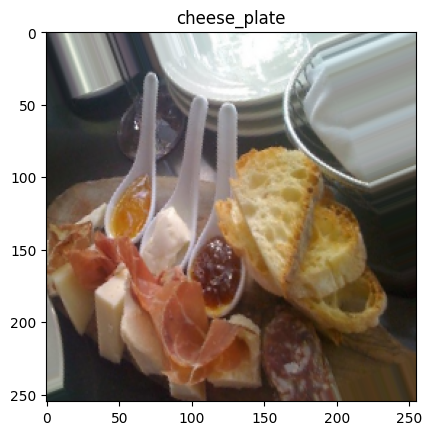

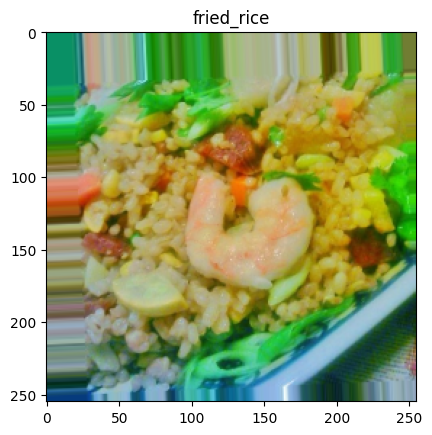

In [ ]:
x_batch, y_batch = next(train_datagen)
foldernames = {v:k for k,v in train_datagen.class_indices.items()}
for i in range(0, 2):
    image = x_batch[i]
    plt.imshow(image)
    plt.title(foldernames[y_batch[i].argmax()])
    plt.show()

## Creating the Neural Network

In [ ]:
# Train the model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(255,255,3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(101, activation='softmax'))

model.summary()

optimizers = Adam(learning_rate=0.0001)

callbacks = [EarlyStopping(patience=10, verbose=1), ModelCheckpoint('drive/MyDrive/best_model.h5', save_best_only=True, verbose=1), ReduceLROnPlateau(factor=0.1, patience=5, verbose=1), TensorBoard(log_dir='logs')]

model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                      

In [ ]:
# Train the model
history = model.fit(train_datagen,steps_per_epoch=1000, validation_data=val_datagen, epochs=1000, callbacks=callbacks)

# Save the model
model.save('drive/MyDrive/model.h5')

Epoch 1/1000
1000/1000 [==============================] - ETA: 0s - loss: 4.2680 - accuracy: 0.0610
Epoch 1: val_loss improved from inf to 2.94261, saving model to drive/MyDrive/best_model.h5
1000/1000 [==============================] - 884s 863ms/step - loss: 4.2680 - accuracy: 0.0610 - val_loss: 2.9426 - val_accuracy: 0.2913 - lr: 1.0000e-04
Epoch 2/1000
1000/1000 [==============================] - ETA: 0s - loss: 2.5946 - accuracy: 0.3493
Epoch 2: val_loss improved from 2.94261 to 1.87260, saving model to drive/MyDrive/best_model.h5
1000/1000 [==============================] - 869s 869ms/step - loss: 2.5946 - accuracy: 0.3493 - val_loss: 1.8726 - val_accuracy: 0.5317 - lr: 1.0000e-04
Epoch 3/1000
1000/1000 [==============================] - ETA: 0s - loss: 1.8730 - accuracy: 0.5282
Epoch 3: val_loss improved from 1.87260 to 1.44464, saving model to drive/MyDrive/best_model.h5
1000/1000 [==============================] - 872s 871ms/step - loss: 1.8730 - accuracy: 0.5282 - val_loss: 1

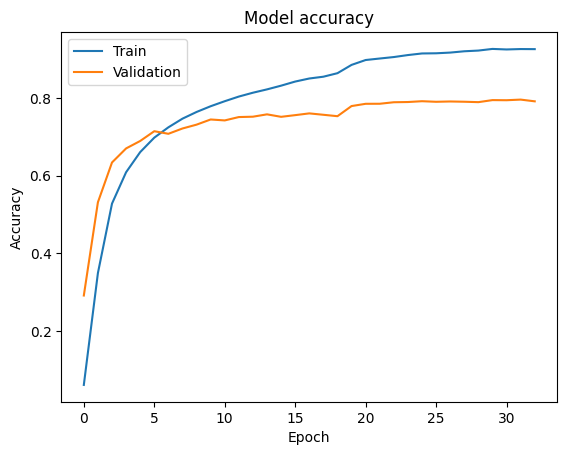

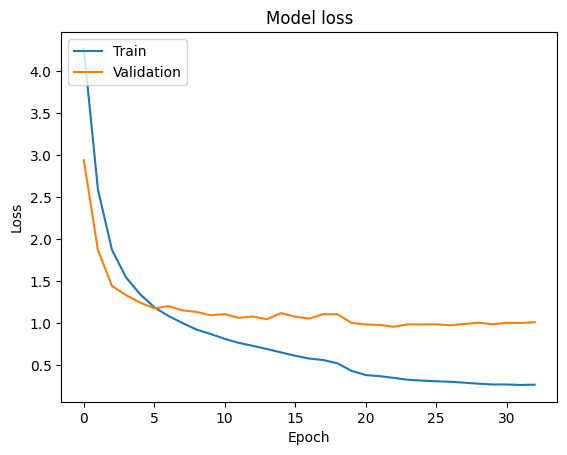

In [ ]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [5]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
import numpy as np

model = load_model('drive/MyDrive/best_model.h5')

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/output/test/', target_size=(255,255), batch_size=32, class_mode='categorical')

Found 20200 images belonging to 101 classes.


In [8]:
model.evaluate(test_generator)


632/632 [==============================] - 111s 164ms/step - loss: 0.9076 - accuracy: 0.8084


[0.9075586199760437, 0.8083663582801819]